In [1]:
pip install scikit-learn xgboost joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib  # This is for saving our final models

# Import everything we need from Scikit-learn
from sklearn.model_selection import train_test_split # We will NOT use this, but good to know
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Import our models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

print("Modeling libraries imported successfully.")

Modeling libraries imported successfully.


In [3]:
# Load the clean, feature-engineered data
df = pd.read_csv('processed_dataset.csv', index_col='timestamp', parse_dates=True)

print("Processed data loaded:")
df.head()

Processed data loaded:


,generation_biomass,generation_lignite_coal,generation_coal_gas,generation_natural_gas,generation_hard_coal,generation_oil,generation_oil_shale,generation_peat,generation_geothermal,generation_hydro_pump_used,...,load_forecast,load_actual,price_forecast,price_actual,hour,day_of_week,month,quarter,day_of_year,year
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447,329,0,4844,4821,162,0,0,0,863,...,26118,25385,50.10,65.41,23,2,12,4,365,2014
2015-01-01 00:00:00+00:00,449,328,0,5196,4755,158,0,0,0,920,...,24934,24382,48.10,64.92,0,3,1,1,1,2015
2015-01-01 01:00:00+00:00,448,323,0,4857,4581,157,0,0,0,1164,...,23515,22734,47.33,64.48,1,3,1,1,1,2015
2015-01-01 02:00:00+00:00,438,254,0,4314,4131,160,0,0,0,1503,...,22642,21286,42.27,59.32,2,3,1,1,1,2015
2015-01-01 03:00:00+00:00,428,187,0,4130,3840,156,0,0,0,1826,...,21785,20264,38.41,56.04,3,3,1,1,1,2015


In [4]:
# Our target is the actual price
TARGET = 'price_actual'

# Our features (X) are ALL columns that are NOT the target
FEATURES = [col for col in df.columns if col != TARGET]

print(f"We will predict this 1 target: {TARGET}")
print(f"Using these {len(FEATURES)} features: {FEATURES}")

We will predict this 1 target: price_actual
Using these 31 features: ['generation_biomass', 'generation_lignite_coal', 'generation_coal_gas', 'generation_natural_gas', 'generation_hard_coal', 'generation_oil', 'generation_oil_shale', 'generation_peat', 'generation_geothermal', 'generation_hydro_pump_used', 'generation_hydro_river', 'generation_hydro_reservoir', 'generation_marine', 'generation_nuclear', 'generation_other', 'generation_other_renewable', 'generation_solar', 'generation_waste', 'generation_wind_offshore', 'generation_wind_onshore', 'solar_forecast', 'wind_onshore_forecast', 'load_forecast', 'load_actual', 'price_forecast', 'hour', 'day_of_week', 'month', 'quarter', 'day_of_year', 'year']


Total data: 35064 hours
Training data: 26305 hours (from 2014-12-31 23:00:00+00:00 to 2017-12-31 23:00:00+00:00)
Testing data: 8759 hours (from 2018-01-01 00:00:00+00:00 to 2018-12-31 22:00:00+00:00)


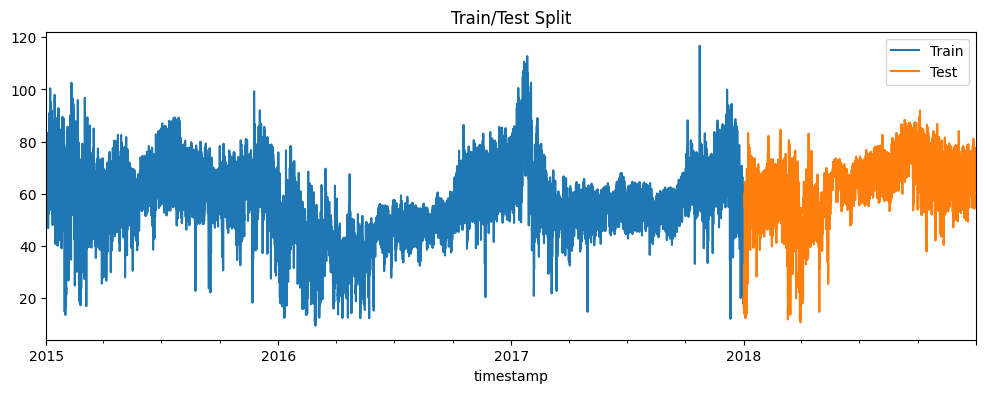

In [5]:
# Our data spans 4 years (2015-2018). Let's use the first 3 years for training
# and the final year (2018) for testing.
split_date = '2018-01-01'

# Split the data
df_train = df.loc[df.index < split_date]
df_test = df.loc[df.index >= split_date]

print(f"Total data: {len(df)} hours")
print(f"Training data: {len(df_train)} hours (from {df_train.index.min()} to {df_train.index.max()})")
print(f"Testing data: {len(df_test)} hours (from {df_test.index.min()} to {df_test.index.max()})")

# Let's visualize the split on our 'price_actual' target
plt.figure(figsize=(12, 4))
df_train[TARGET].plot(label='Train')
df_test[TARGET].plot(label='Test')
plt.title('Train/Test Split')
plt.legend()

plt.savefig('train_test_split.png')
plt.show()

In [6]:
# Initialize the scaler
scaler = StandardScaler()

# 1. Scale Features (X)
# Fit and transform the training features
X_train_scaled = scaler.fit_transform(df_train[FEATURES])
# ONLY transform the test features (no 'fit'!)
X_test_scaled = scaler.transform(df_test[FEATURES])

# 2. Separate our Targets (y)
y_train = df_train[TARGET]
y_test = df_test[TARGET]

print("Data has been split and scaled.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train shape: {y_train.shape}")

Data has been split and scaled.
X_train_scaled shape: (26305, 31)
y_train shape: (26305,)


In [7]:
# 1. Define the models we want to try
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, early_stopping_rounds=10)
}

# 2. Create places to store our results and trained models
results = []
trained_models = {}

print("--- Starting Model Training ---")

# 3. Loop through each model
for name, model in models.items():
    print(f"--- Training {name} ---")
    
    # XGBoost has a special feature to prevent overfitting
    if name == 'XGBoost':
        model.fit(X_train_scaled, y_train,
                  eval_set=[(X_test_scaled, y_test)], # It tests itself as it trains
                  verbose=False)
    else:
        model.fit(X_train_scaled, y_train)
        
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate the model
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"✅ {name} complete. R2 Score: {r2:.4f}, MAE: {mae:.4f}")
    
    # Store results
    results.append({'Model': name, 'R2 Score': r2, 'MAE': mae})
    trained_models[name] = model # Save the trained model
        
print("🎉 All training complete!")

# Create a DataFrame to see results clearly
results_df = pd.DataFrame(results).sort_values(by='MAE')
results_df

--- Starting Model Training ---
--- Training Linear Regression ---
✅ Linear Regression complete. R2 Score: 0.4984, MAE: 5.8154
--- Training Random Forest ---
✅ Random Forest complete. R2 Score: 0.2772, MAE: 7.5585
--- Training XGBoost ---
✅ XGBoost complete. R2 Score: 0.3853, MAE: 6.9552
🎉 All training complete!


,Model,R2 Score,MAE
0,Linear Regression,0.498351,5.815379
2,XGBoost,0.385337,6.955206
1,Random Forest,0.277226,7.558520


Plotting results for one week in January 2018...


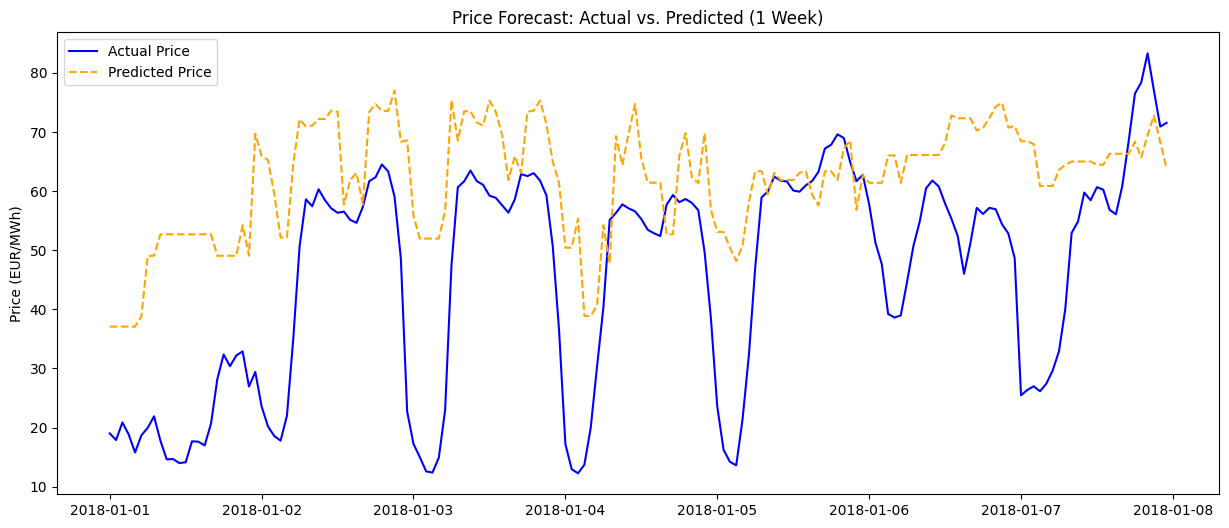

In [8]:
# 1. Get our best model (XGBoost)
best_model = trained_models['XGBoost']

# 2. Make predictions
y_pred = best_model.predict(X_test_scaled)

# 3. Add predictions to our test DataFrame to make plotting easy
df_results = df_test.copy()
df_results['price_prediction'] = y_pred

print("Plotting results for one week in January 2018...")

# 4. Plot the first week of our test set (168 hours)
plot_data = df_results.iloc[:168]

plt.figure(figsize=(15, 6))
plt.plot(plot_data.index, plot_data['price_actual'], label='Actual Price', color='blue')
plt.plot(plot_data.index, plot_data['price_prediction'], label='Predicted Price', color='orange', linestyle='--')
plt.legend()
plt.title('Price Forecast: Actual vs. Predicted (1 Week)')
plt.ylabel('Price (EUR/MWh)')

plt.savefig('price_forecast_1_week.png')
plt.show()

In [9]:
# We'll save our best model (XGBoost)
joblib.dump(trained_models['XGBoost'], 'model_price_forecast.joblib')

# CRITICAL: We must also save the scaler. We need it to process new data.
joblib.dump(scaler, 'scaler.joblib')

print("Best model and the data scaler have been saved to .joblib files!")
print("We are now ready for Week 3.")

Best model and the data scaler have been saved to .joblib files!
We are now ready for Week 3.
